In [1]:
import sys
sys.executable
import torch
import pytorch_lightning as pl

import tensorflow as tf
import tensorboard as tb


print(torch.__version__)
print(pl.__version__)
import torch
print(torch.cuda.is_available())

1.11.0+cu113
1.7.0
True


In [2]:
import pandas as pd
import numpy as np

from torchmetrics import Accuracy, Precision, Recall, F1Score
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import NaNLabelEncoder

import torchmetrics
import torch
import pytorch_forecasting.metrics as metrics
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import CrossEntropy,QuantileLoss
import torch.nn as nn

data = pd.read_csv('TSLA-5y.csv')


data['Date'] = pd.to_datetime(data['Date'])
data['time_idx'] = data.index
data['group_ids']=0

data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(str)
data['Day'] = pd.to_datetime(data['Date']).dt.day.astype(str)
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,time_idx,group_ids,Year,Month,Day
0,2019-07-29,15.139333,15.729333,15.068667,15.718000,15.718000,139099500,0,0,2019,7,29
1,2019-07-30,15.526667,16.224001,15.478667,16.150667,16.150667,121635000,1,0,2019,7,30
2,2019-07-31,16.200001,16.445333,15.776667,16.107332,16.107332,137673000,2,0,2019,7,31
3,2019-08-01,16.176666,16.300667,15.451333,15.590000,15.590000,123892500,3,0,2019,8,1
4,2019-08-02,15.423333,15.751333,15.282000,15.622667,15.622667,92047500,4,0,2019,8,2
5,2019-08-05,15.306667,15.424667,15.052000,15.221333,15.221333,105424500,5,0,2019,8,5
6,2019-08-06,15.458667,15.500000,15.050000,15.383333,15.383333,83463000,6,0,2019,8,6
7,2019-08-07,15.100000,15.571333,15.053333,15.561333,15.561333,71647500,7,0,2019,8,7
8,2019-08-08,15.630000,15.986667,15.510000,15.886667,15.886667,79114500,8,0,2019,8,8
9,2019-08-09,15.736667,15.930667,15.587333,15.667333,15.667333,58473000,9,0,2019,8,9


In [3]:
import torch.nn.functional as F

data = data.head(len(data) - 176)

test_length= 5
max_prediction_length = 5 
max_encoder_length = 300

test_cutoff = data["time_idx"].max() - test_length  
used_data = data[data["time_idx"] <= test_cutoff]
test_data = data[data["time_idx"] > test_cutoff]

training_cutoff = used_data['time_idx'].max() - max_prediction_length
training = used_data[used_data['time_idx'] <= training_cutoff]
validation = used_data[used_data['time_idx'] > training_cutoff]
print(data[data['time_idx'] == data['time_idx'].max()])
Memory_data=float(data[data['time_idx'] == data['time_idx'].max()-test_length-max_prediction_length-1]['Close'])


           Date        Open        High         Low       Close   Adj Close  \
1081 2023-11-10  210.029999  215.380005  205.690002  214.649994  214.649994   

         Volume  time_idx  group_ids  Year Month Day  
1081  130994000      1081          0  2023    11  10  


In [4]:

np.float=np.float64

training_dataset = TimeSeriesDataSet(
    used_data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    used_data, 
    predict=True, 
    stop_randomization=True
)

used_dataset = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= test_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)
test_dataset = TimeSeriesDataSet.from_dataset(
    used_dataset,  
    data, 
    predict=True, 
    stop_randomization=True 
)


batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

import random

pl.seed_everything(42)
from torchmetrics import SpearmanCorrCoef

class CustomQuantileLoss(torchmetrics.Metric):
    def __init__(self, quantiles, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.quantiles = quantiles
        self.add_state("total_loss", default=torch.tensor(0.0), dist_reduce_fx="sum")
    
    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Since the loss calculates trends, the previous data for the forecast is recorded and pasted here
        prev_true = torch.tensor([Memory_data]).to(device)
        y_true = torch.cat((prev_true, y_true), dim=0).to(device)
        y_pred = torch.cat((prev_true, y_pred), dim=0).to(device)
        
        trend_pred = torch.sign(y_pred[1:] - y_pred[:-1])
        trend_true = torch.sign(y_true[1:] - y_true[:-1])
        mse_loss = F.mse_loss(y_pred, y_true, reduction='mean')
        
       
        spearman_corr = SpearmanCorrCoef()(y_pred, y_true)
        spearman_corr_loss = 1 - spearman_corr #Convert to loss
        combined_loss = 2 * mse_loss + 5 * spearman_corr_loss
        
        loss = torch.mean(combined_loss)
        

        self.total_loss += loss
    
    def compute(self):
        return self.total_loss

quantiles = [0.1, 0.5, 0.9] 
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.1,
    hidden_size=128,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=128,
    loss = CustomQuantileLoss(quantiles=quantiles),
    log_interval=10,
)
print(dir(torchmetrics))
print('\n')
print(dir(pl.callbacks))

Global seed set to 42


['AUC', 'AUROC', 'Accuracy', 'AveragePrecision', 'BLEUScore', 'BinnedAveragePrecision', 'BinnedPrecisionRecallCurve', 'BinnedRecallAtFixedPrecision', 'BootStrapper', 'CHRFScore', 'CalibrationError', 'CatMetric', 'CharErrorRate', 'CohenKappa', 'ConfusionMatrix', 'CosineSimilarity', 'ExplainedVariance', 'ExtendedEditDistance', 'F1', 'F1Score', 'FBeta', 'FBetaScore', 'HammingDistance', 'Hinge', 'HingeLoss', 'IoU', 'JaccardIndex', 'KLDivergence', 'MatchErrorRate', 'MatthewsCorrCoef', 'MatthewsCorrcoef', 'MaxMetric', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MeanMetric', 'MeanSquaredError', 'MeanSquaredLogError', 'Metric', 'MetricCollection', 'MetricTracker', 'MinMaxMetric', 'MinMetric', 'MultiScaleStructuralSimilarityIndexMeasure', 'MultioutputWrapper', 'PIT', 'PSNR', 'PeakSignalNoiseRatio', 'PearsonCorrCoef', 'PearsonCorrcoef', 'PermutationInvariantTraining', 'Precision', 'PrecisionRecallCurve', 'R2Score', 'ROC', 'Recall', 'RetrievalFallOut', 'RetrievalHitRate', 'RetrievalMAP',

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [5]:
import tensorflow as tf
import tensorboard as tb
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning import Callback
import pytorch_lightning.loggers as pl_loggers
import logging
logging.basicConfig(level=logging.INFO)

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

optimizer = torch.optim.Adam(tft.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.5, 
                              patience=2,
                              verbose=True, 
                              min_lr=1e-6
                             )
lr_monitor = LearningRateMonitor(logging_interval='step')


class LRSchedulerCallback(Callback):
    def __init__(self, scheduler):
        self.scheduler = scheduler

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.scheduler.step(val_loss)
        
scheduler_callback = LRSchedulerCallback(scheduler)


trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=2,
    log_every_n_steps=10,
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=8, 
                             mode='min',
                             verbose=True),
               lr_monitor,
               scheduler_callback,
               ModelCheckpoint(monitor='val_loss',
                               mode='min',
                               save_top_k=1,
                               verbose=True)
              ],

)


trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 413   
3  | prescalers                         | ModuleDict                      | 3.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 200 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 614 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 271 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on th

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 4506.875
Epoch 0, global step 8: 'val_loss' reached 4506.87500 (best 4506.87500), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_139\\checkpoints\\epoch=0-step=8.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3567.296 >= min_delta = 0.0. New best score: 939.579
Epoch 1, global step 16: 'val_loss' reached 939.57886 (best 939.57886), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_139\\checkpoints\\epoch=1-step=16.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 361.440 >= min_delta = 0.0. New best score: 578.139
Epoch 2, global step 24: 'val_loss' reached 578.13892 (best 578.13892), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_139\\checkpoints\\epoch=2-step=24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 383.397 >= min_delta = 0.0. New best score: 194.742
Epoch 3, global step 32: 'val_loss' reached 194.74152 (best 194.74152), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_139\\checkpoints\\epoch=3-step=32.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 40: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 48: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 56: 'val_loss' was not in top 1


Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 64: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 93.284 >= min_delta = 0.0. New best score: 101.458
Epoch 8, global step 72: 'val_loss' reached 101.45793 (best 101.45793), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_139\\checkpoints\\epoch=8-step=72.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 80: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 88: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 96: 'val_loss' was not in top 1


Epoch 00012: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 104: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 112: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 120: 'val_loss' was not in top 1


Epoch 00015: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 128: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 8 records. Best score: 101.458. Signaling Trainer to stop.
Epoch 16, global step 136: 'val_loss' was not in top 1


In [6]:

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

predictions = best_tft.predict(val_dataloader)

mae = (actuals - predictions).abs().mean()

print(f'MAE: {mae}')


MAE: 6.197665214538574


In [7]:
import matplotlib.pyplot as plt
import torch

predictions_np = predictions.numpy()
actuals_np = actuals.numpy()
validation1=validation['Close'].tolist()

data1 = used_data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = predictions_np[0]
forecast_actuals = validation1

predictions_np = [last_historical_point] + list(forecast_predictions)
validation1 = [last_historical_point] + list(forecast_actuals)

print(len(predictions_np),':',len(predictions_np),'\n')
print(predictions_np[1:],'\n', validation1[1:])

6 : 6 

[201.75162, 214.03079, 215.79901, 217.2066, 217.99649] 
 [197.360001, 200.839996, 205.660004, 218.509995, 219.960007]


Mean Absolute Error: 6.197665483203122
Mean Absolute Percentage Error: 2.9077834585027005%
Root Mean Squared Error: 7.767072718461209
Mean Absolute Error: 6.197665483203122
Spearman's rho (ρ): 0.9999999999999999
Spearman's p_value: 1.4042654220543672e-24


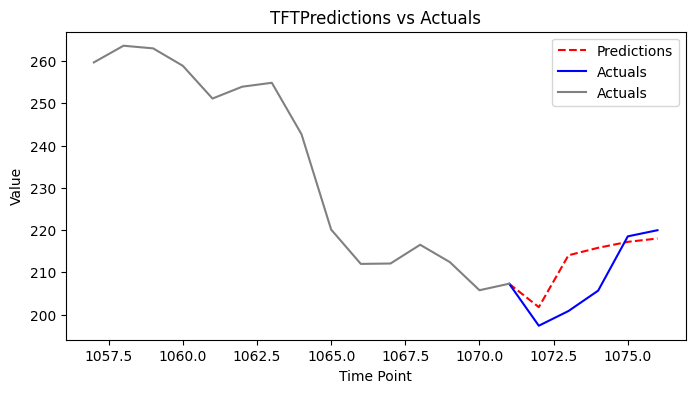

In [8]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

data1=used_data['Close']
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(predictions_np[1:], validation1[1:])

print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(predictions_np[1:], validation1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(predictions_np[1:], validation1[1:]))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(predictions_np[1:], validation1[1:])

print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")
plt.figure(figsize=(8, 4))


plt.plot(data1.index[-6:], predictions_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], validation1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-20:-5], data1[-20:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

1


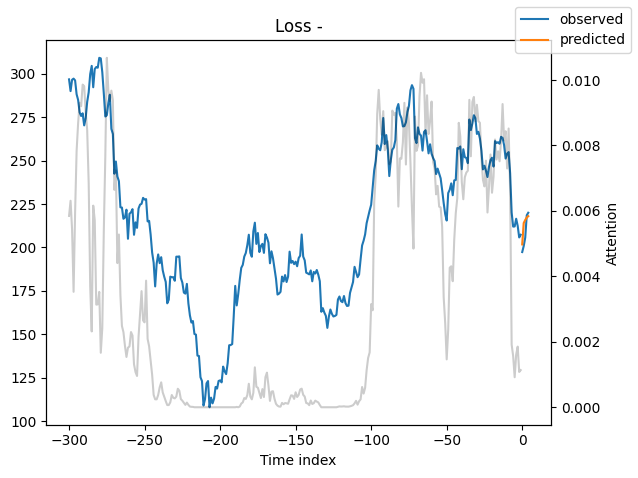

In [9]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(len(raw_predictions['encoder_lengths']) )
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x475 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

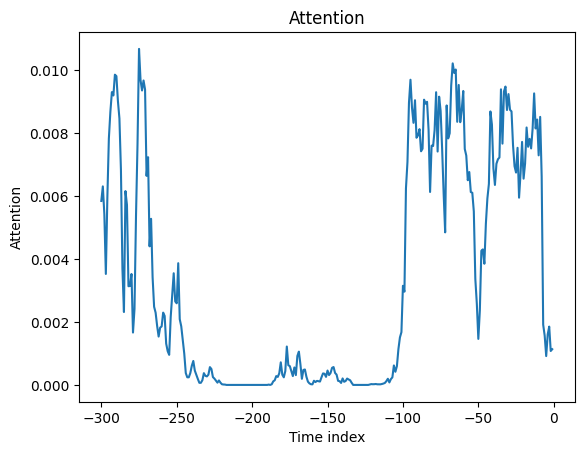

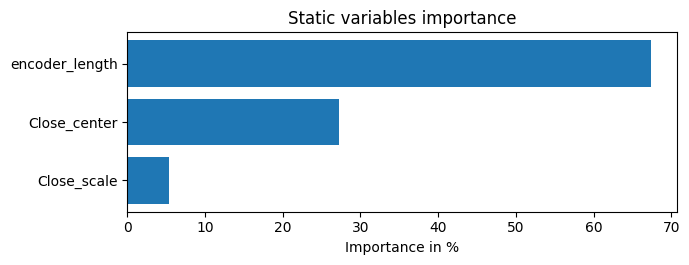

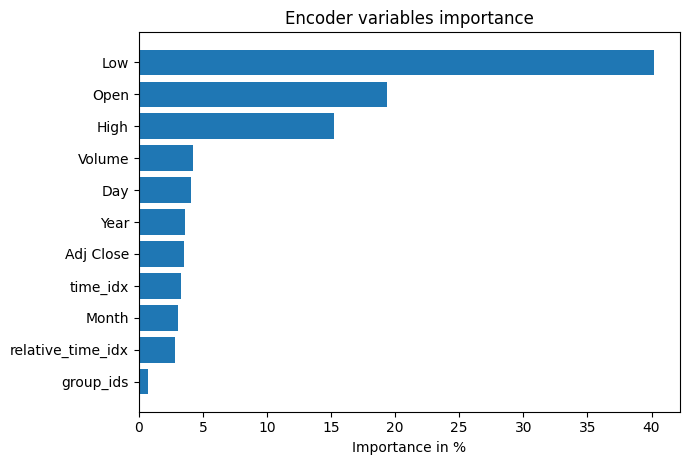

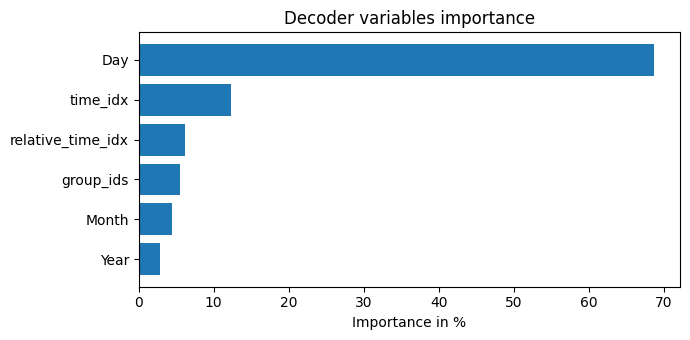

In [10]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [11]:
torch.save(best_tft.state_dict(), 'TFT-model-weights.pth')

In [12]:
best_tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.1,
    hidden_size=128,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=128,
    loss = CustomQuantileLoss(quantiles=quantiles),
    log_interval=10,
    reduce_on_plateau_patience=4
)

best_tft.load_state_dict(torch.load('TFT-model-weights.pth'))


C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<All keys matched successfully>

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\

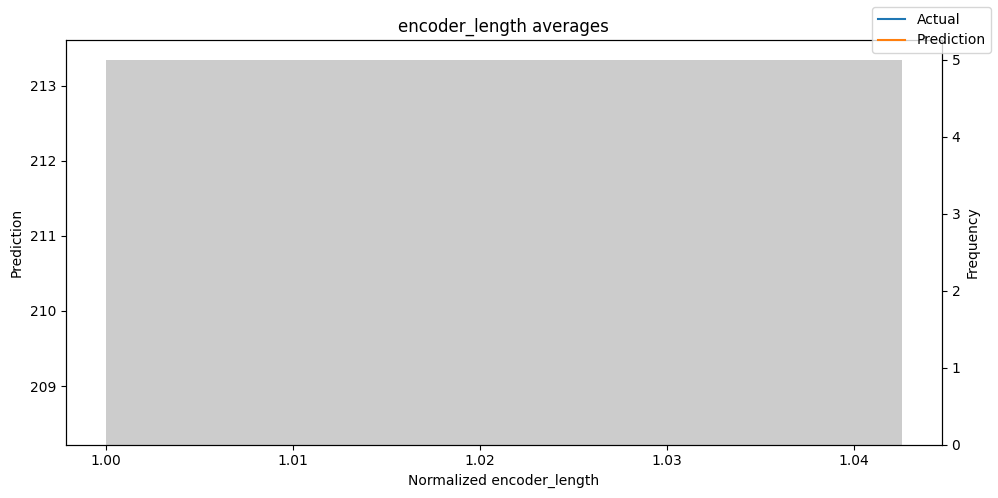

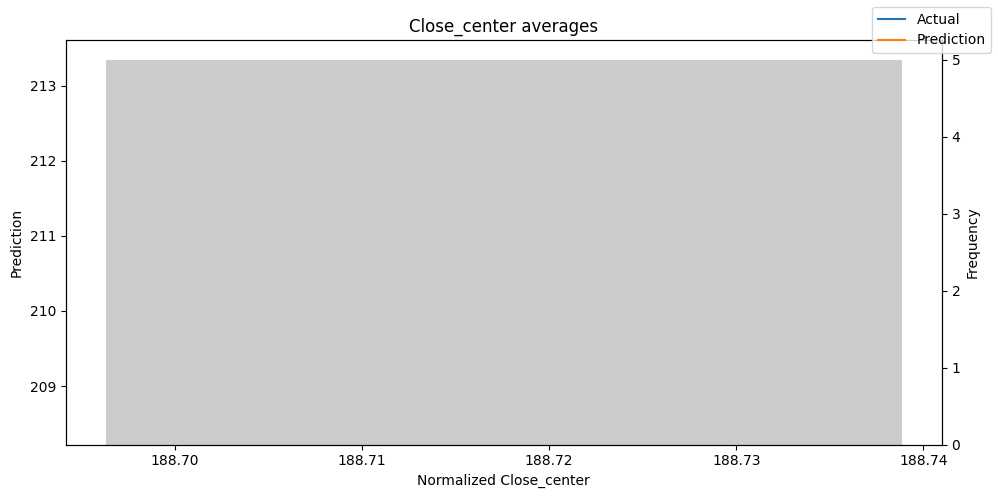

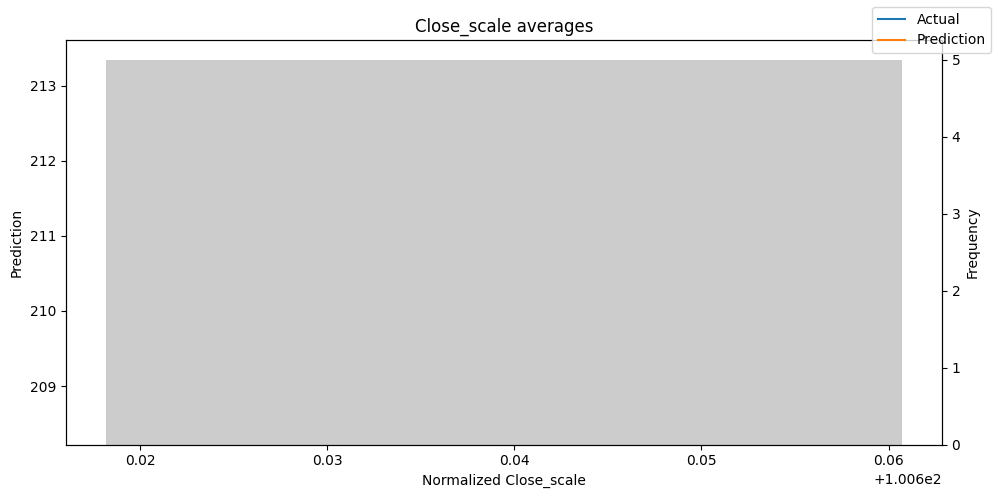

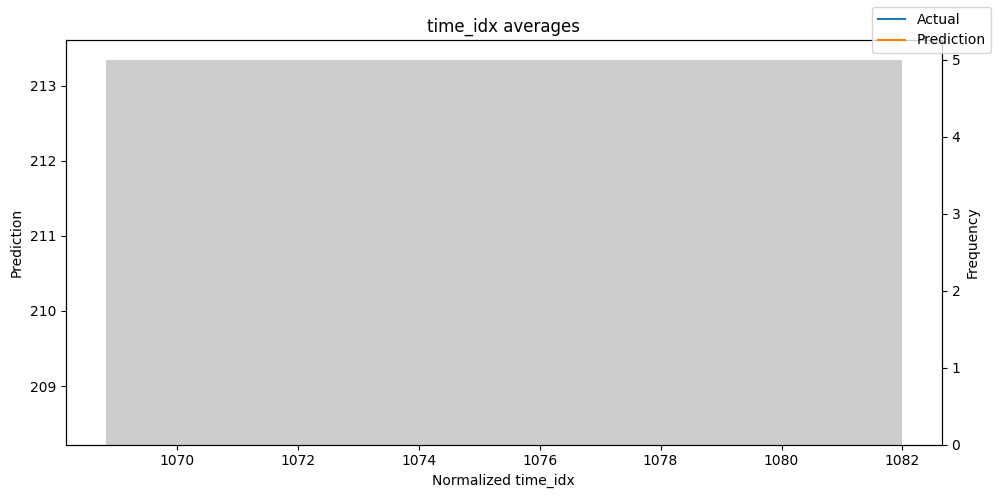

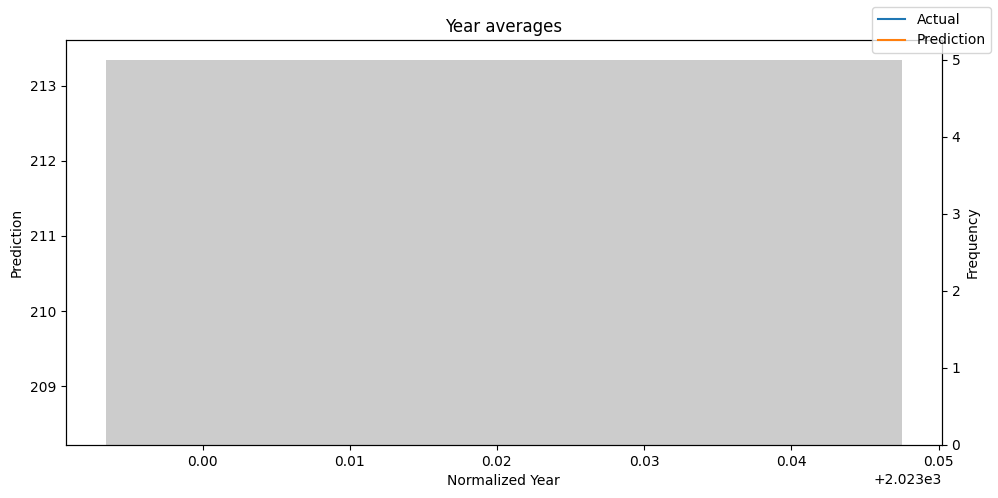

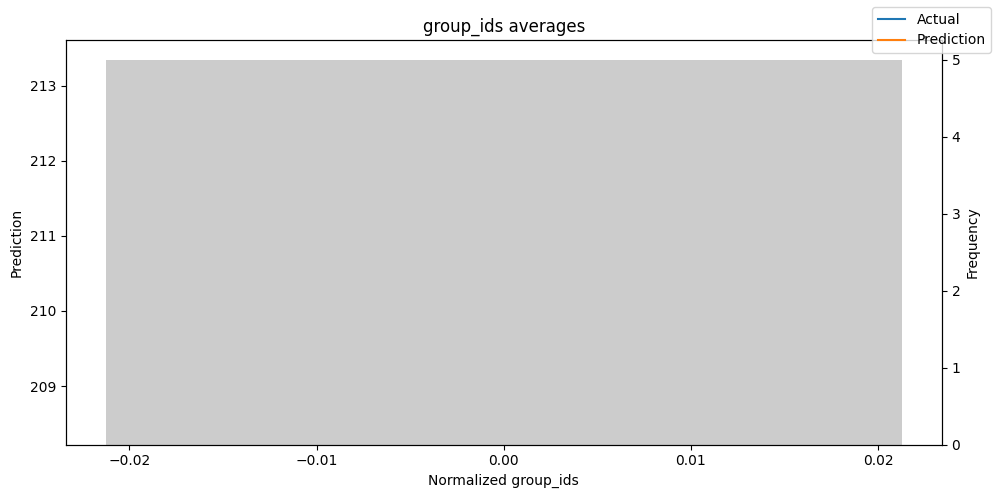

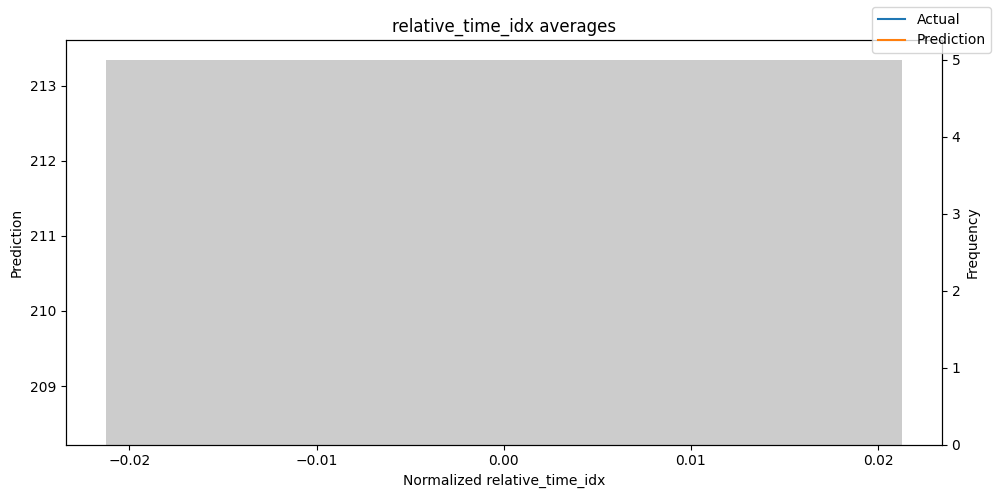

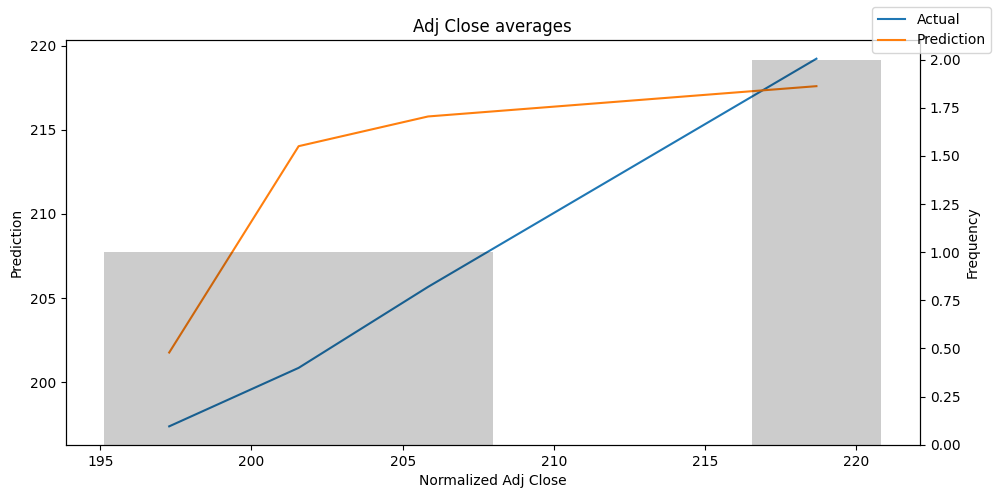

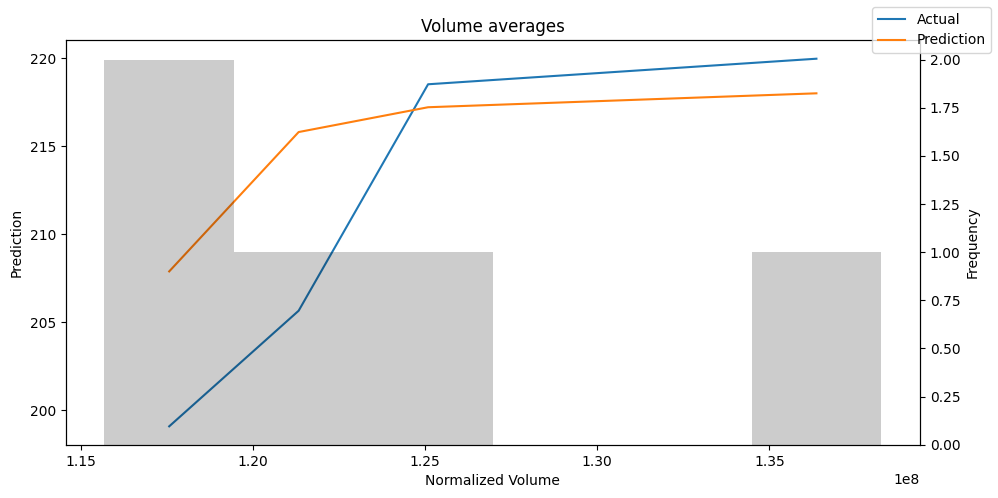

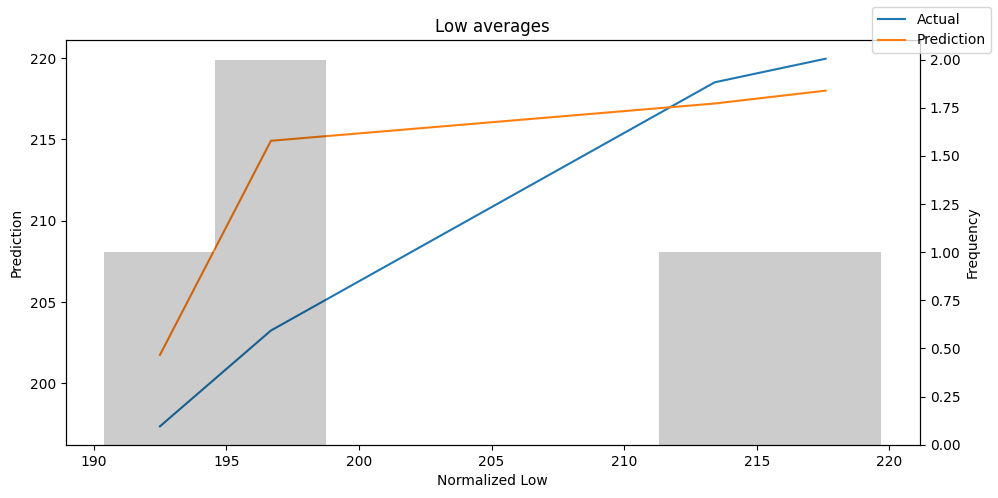

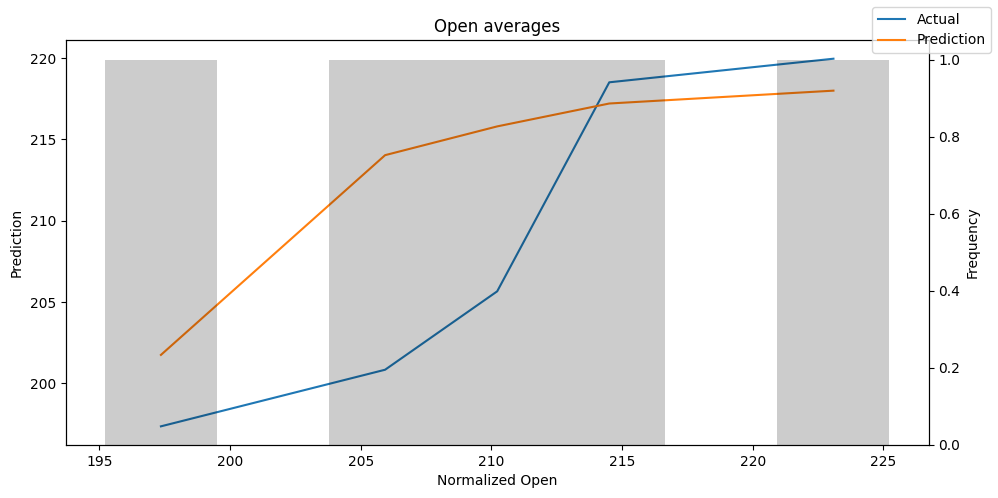

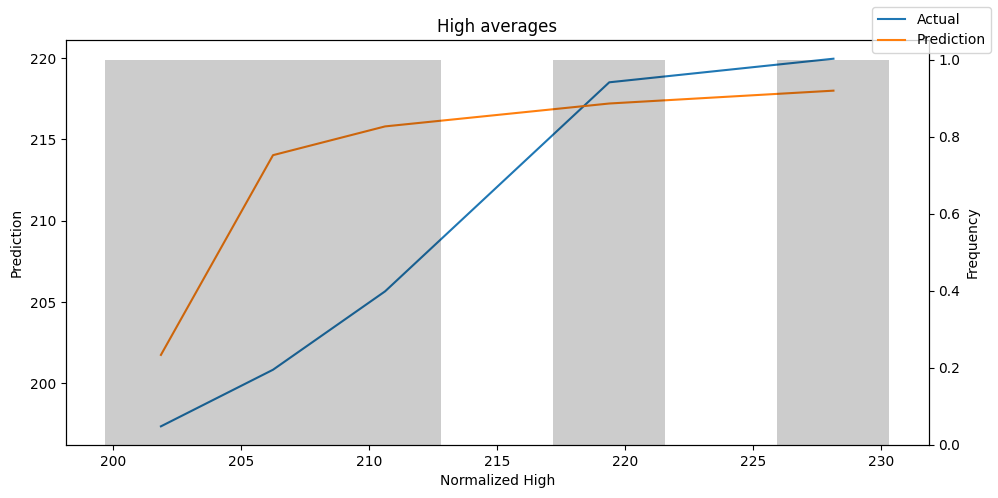

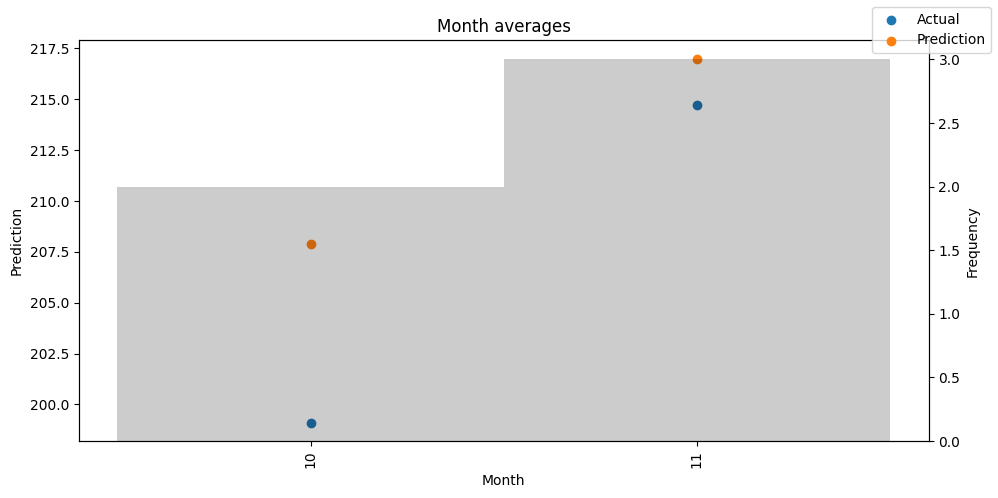

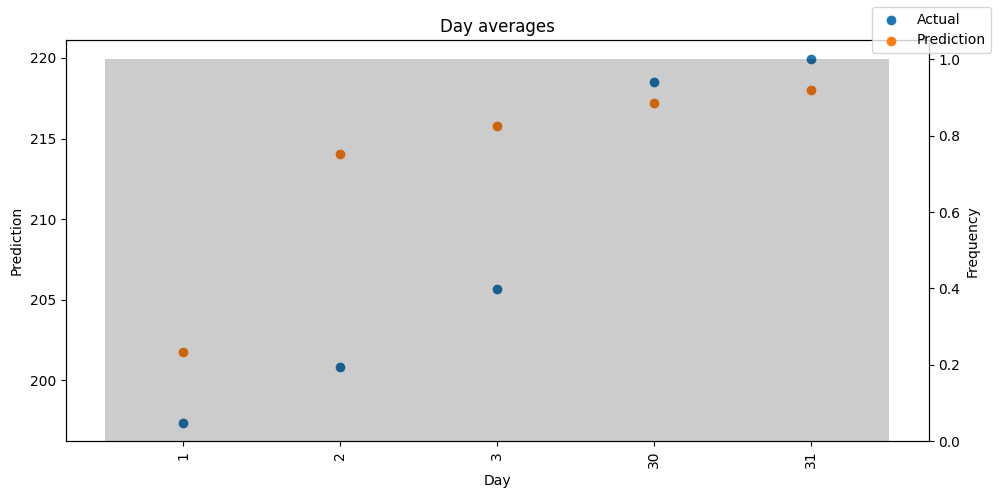

In [13]:

predictions, x = best_tft.predict(val_dataloader, return_x=True,)

predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions, normalize=True)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [14]:

test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])

test_results = best_tft.predict(test_dataloader)

mae = (test_actuals - test_results).abs().mean()

print(f'VAL-MAE: {mae}')


VAL-MAE: 10.609140396118164


In [15]:
import matplotlib.pyplot as plt
import torch

test_results_np = test_results.numpy()
test_actuals_np = test_actuals.numpy()
test_data1=test_data['Close'].tolist()

data1 = data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = test_results_np[0]
forecast_actuals = test_data1
print(forecast_actuals)

[219.270004, 222.179993, 222.110001, 209.979996, 214.649994]


6 : 6 

[208.54683, 207.39966, 210.65485, 208.49088, 200.05208] 
 [219.270004, 222.179993, 222.110001, 209.979996, 214.649994]
Mean Absolute Error: 10.609140178125
Mean Absolute Percentage Error: 5.1435055954862055%
Root Mean Squared Error: 11.661749188147066
Mean Absolute Error: 10.609140178125
Spearman's rho (ρ): 0.19999999999999998
Spearman's p_value: 0.747060078104662


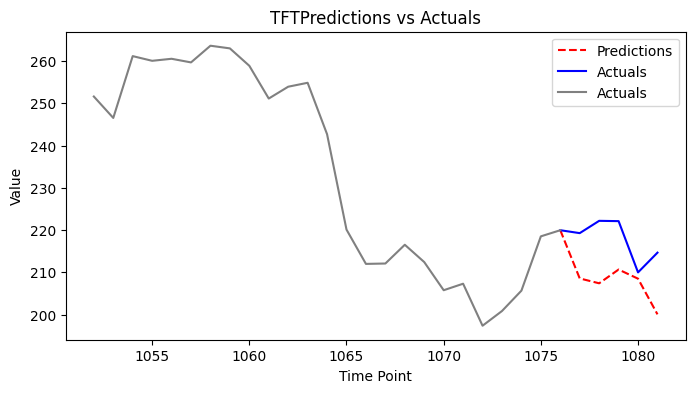

In [16]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_results_np = [last_historical_point] + list(forecast_predictions)
test_data1 = [last_historical_point] + list(forecast_actuals)

print(len(test_results_np),':',len(test_data1),'\n')
print(test_results_np[1:],'\n', test_data1[1:])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_results_np[1:], test_data1[1:])

print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(test_results_np[1:], test_data1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(test_results_np[1:], test_data1[1:]))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_results_np[1:], test_data1[1:])

print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")

plt.figure(figsize=(8, 4))


plt.plot(data1.index[-6:], test_results_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], test_data1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

1


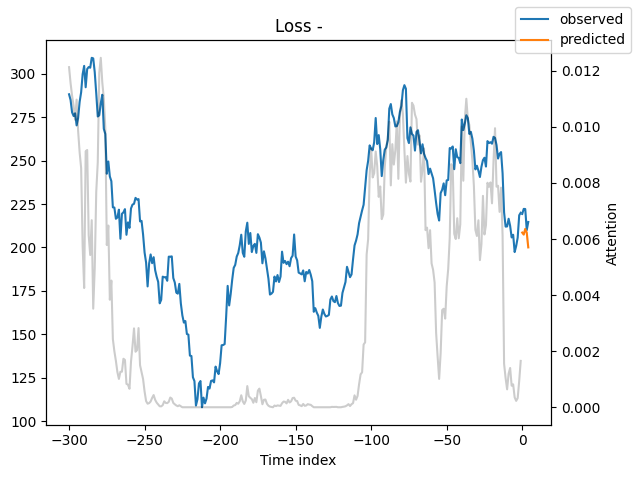

In [17]:
test_raw_predictions, test_x = best_tft.predict(test_dataloader, mode="raw", return_x=True)
print(len(test_raw_predictions['encoder_lengths']))
best_tft.plot_prediction(test_x, test_raw_predictions, idx=0, add_loss_to_title=True);